In [0]:
import os
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip

%matplotlib inline

In [0]:
#!pip install utils
from importlib import reload
import utils; reload(utils)
from utils import *

In [0]:
calibration_dir = "repo/camera_cal"
test_imgs_dir = "repo/test_images"
output_imgs_dir = "repo/output_images"
output_videos_dir = "repo/output_videos"

In [0]:
cal_imgs_paths = glob.glob(calibration_dir + "/*.jpg")

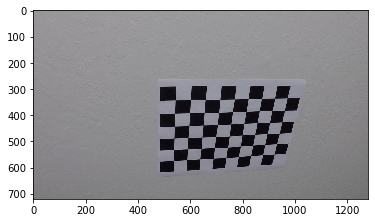

In [0]:
from tensorflow.keras.preprocessing.image import load_img
cal_img_path = cal_imgs_paths[1]
cal_img = load_img(cal_img_path)
plt.imshow(cal_img)

In [0]:
NX = 9
NY = 6

In [0]:
def chessboard_get_corners(imgs, nx, ny):
    """Return image and object points from set of chessboard images."""
    if not isinstance(imgs, list):
        raise ValueError("imgs parameters needs to be a list.")
    # Initialize 3D object points
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    imgps = []
    objps = []
    for img in imgs:
        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Detect chessboard corners
        found, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if not found:
            continue
        imgps.append(corners)
        objps.append(objp)
    return imgps, objps

def chessboard_cam_calib(imgps, objps, img_size):
    """Returns camera calibration matrix and distortion coefficients"""
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objps, imgps, img_size, None, None)
    return mtx, dist

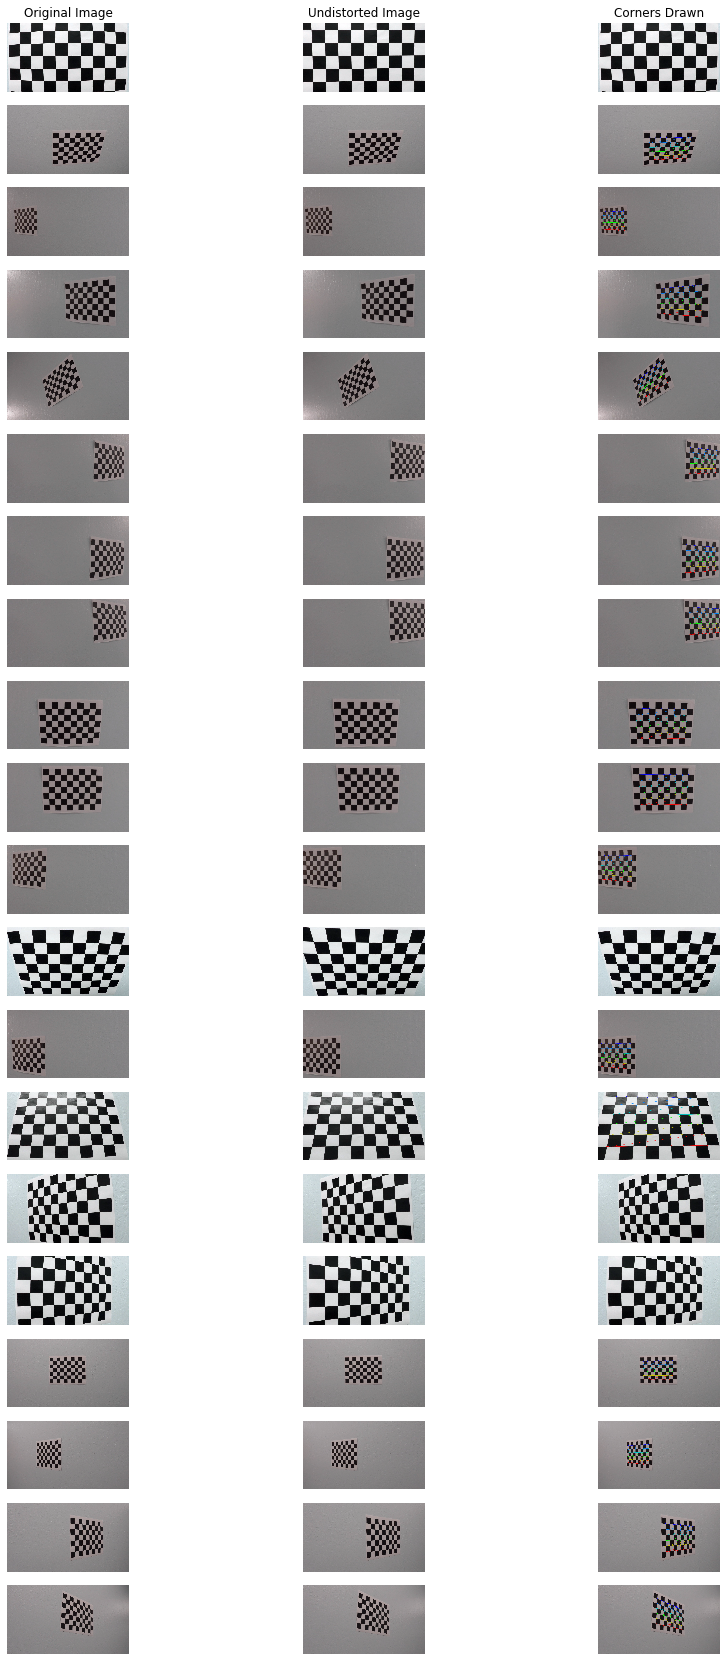

In [0]:
# Retrieve path to all chessboard images
img_locs = glob.glob(calibration_dir + "/*.jpg")

# Read all images into a list
imgs = []
for img_loc in img_locs:
    img = cv2.imread(img_loc)
    imgs.append(img)
    
# Get size of images using one image as a sample, with width as first element
img_size = imgs[0].shape[::-1][1:]

# Calibrate camera and retrieve calibration matrix and distortion coeddicients
imgps, objps = chessboard_get_corners(imgs, NX, NY)
MTX, DIST = chessboard_cam_calib(imgps, objps, img_size)

# Set up figure for plotting
f, axarr = plt.subplots(len(imgs), 3)
f.set_size_inches(15, 30)

# Loop through images, undistory them, and draw corners on undistorted versions.
for i, img in enumerate(imgs):
    # Set column headings on figure
    if i == 0:
        axarr[i, 0].set_title("Original Image")
        axarr[i, 1].set_title("Undistorted Image")
        axarr[i, 2].set_title("Corners Drawn")
        
    # Generate new undistorted image
    undist = cv2.undistort(img, MTX, DIST, None, MTX)
    # Generate new image with corner points drawn
    undist_copy = undist.copy()
    undist_grey = cv2.cvtColor(undist_copy, cv2.COLOR_BGR2GRAY)
    found, corners = cv2.findChessboardCorners(undist_grey, (NX, NY), None)
    if found:
        drawn = cv2.drawChessboardCorners(undist_copy, (NX, NY), corners, found)
    else:
        drawn = img
    
    # Plot images on figure
    axarr[i, 0].imshow(img)
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(undist)
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(drawn)
    axarr[i, 2].axis('off')

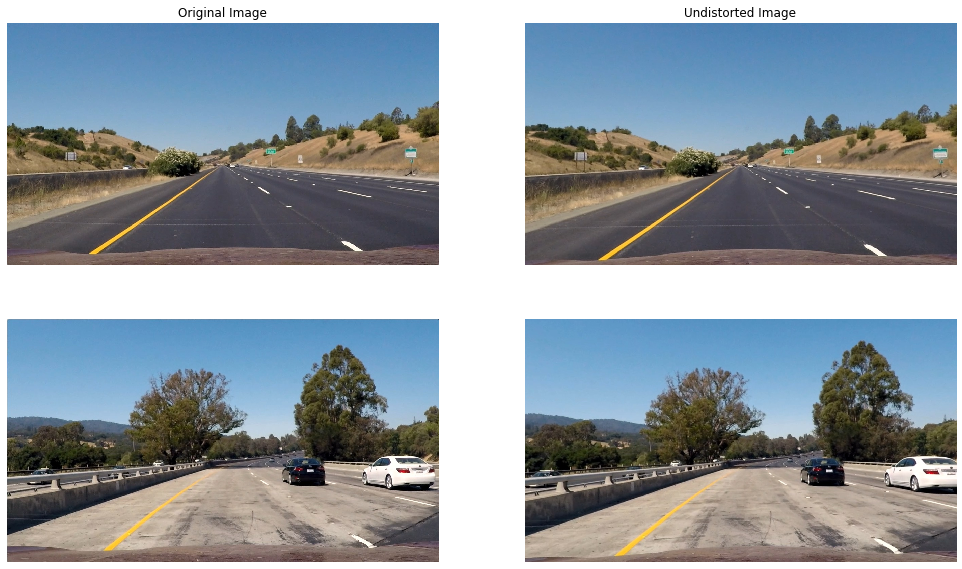

In [0]:
if not "MTX" in globals():
    raise ValueError("Please run Main section above to generate required camera calibration coefficients.")

TEST_IMG = "repo\\test_images\\straight_lines1.jpg"
lane_test_img = cv2.imread(TEST_IMG)
lane_test_img_rgb = cv2.cvtColor(lane_test_img, cv2.COLOR_BGR2RGB)
lane_test_undist = cv2.undistort(lane_test_img_rgb, MTX, DIST, None, MTX)

TEST_IMG2 = "repo\\test_images\\test1.jpg"
lane_test_img2 = cv2.imread(TEST_IMG2)
lane_test_img2_rgb = cv2.cvtColor(lane_test_img2, cv2.COLOR_BGR2RGB)
lane_test_undist2 = cv2.undistort(lane_test_img2_rgb, MTX, DIST, None, MTX)

f, axarr = plt.subplots(2,2)
f.set_size_inches(17, 10)
axarr[0, 0].imshow(lane_test_img_rgb)
axarr[0, 1].imshow(lane_test_undist)
axarr[0, 0].set_title("Original Image")
axarr[0, 1].set_title("Undistorted Image")
axarr[0, 0].axis('off')
axarr[0, 1].axis('off')
axarr[1, 0].imshow(lane_test_img2_rgb)
axarr[1, 1].imshow(lane_test_undist2)
axarr[1, 0].axis('off')
axarr[1, 1].axis('off');

In [0]:
GRADIENT_THRESH = (20, 100)
S_CHANNEL_THRESH = (80, 255)
L_CHANNEL_THRESH = (80, 255)
B_CHANNEL_THRESH = (150, 200)
L2_CHANNEL_THRESH = (225, 255)

In [0]:

def seperate_hls(rgb_img):
    hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    return h, l, s

def seperate_lab(rgb_img):
    lab = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2Lab)
    l = lab[:,:,0]
    a = lab[:,:,1]
    b = lab[:,:,2]
    return l, a, b

def seperate_luv(rgb_img):
    luv = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2Luv)
    l = luv[:,:,0]
    u = luv[:,:,1]
    v = luv[:,:,2]
    return l, u, v

def binary_threshold_lab_luv(rgb_img, bthresh, lthresh):
    l, a, b = seperate_lab(rgb_img)
    l2, u, v = seperate_luv(rgb_img)
    binary = np.zeros_like(l)
    binary[
        ((b > bthresh[0]) & (b <= bthresh[1])) |
        ((l2 > lthresh[0]) & (l2 <= lthresh[1]))
    ] = 1
    return binary

def binary_threshold_hls(rgb_img, sthresh, lthresh):
    h, l, s = seperate_hls(rgb_img)
    binary = np.zeros_like(h)
    binary[
        ((s > sthresh[0]) & (s <= sthresh[1])) &
        ((l > lthresh[0]) & (l <= lthresh[1]))
    ] = 1
    return binary

def gradient_threshold(channel, thresh):
    # Take the derivative in x
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0)
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold gradient channel
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

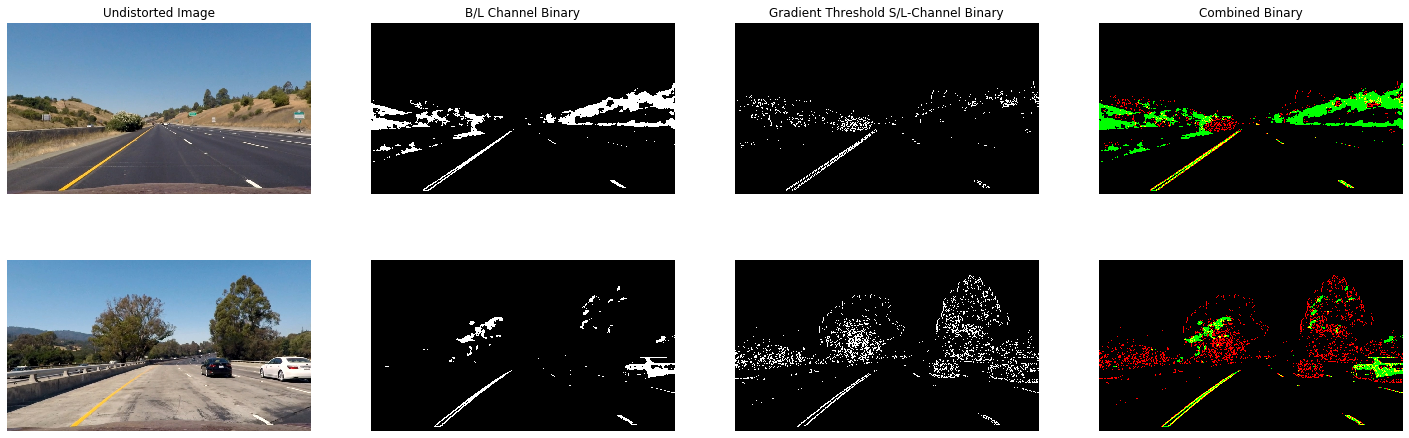

In [0]:
# LAB and LUV channel threshold
s_binary = binary_threshold_lab_luv(lane_test_undist, B_CHANNEL_THRESH, L2_CHANNEL_THRESH)
s_binary2 = binary_threshold_lab_luv(lane_test_undist2, B_CHANNEL_THRESH, L2_CHANNEL_THRESH)

# Gradient threshold on S channel
h, l, s = seperate_hls(lane_test_undist)
sxbinary = gradient_threshold(s, GRADIENT_THRESH)

h2, l2, s2 = seperate_hls(lane_test_undist2)
sxbinary2 = gradient_threshold(s2, GRADIENT_THRESH)

# Combine two binary images to view their contribution in green and red
color_binary = np.dstack((sxbinary, s_binary, np.zeros_like(sxbinary))) * 255
color_binary2 = np.dstack((sxbinary2, s_binary2, np.zeros_like(sxbinary2))) * 255

# Draw figure for binary images
f, axarr = plt.subplots(2,4)
f.set_size_inches(25, 8)
axarr[0, 0].imshow(lane_test_undist)
axarr[0, 1].imshow(s_binary, cmap='gray')
axarr[0, 2].imshow(sxbinary, cmap='gray')
axarr[0, 3].imshow(color_binary)
axarr[0, 0].set_title("Undistorted Image")
axarr[0, 1].set_title("B/L Channel Binary")
axarr[0, 2].set_title("Gradient Threshold S/L-Channel Binary")
axarr[0, 3].set_title("Combined Binary")
axarr[0, 0].axis('off')
axarr[0, 1].axis('off')
axarr[0, 2].axis('off')
axarr[0, 3].axis('off')
axarr[1, 0].imshow(lane_test_undist2)
axarr[1, 1].imshow(s_binary2, cmap='gray')
axarr[1, 2].imshow(sxbinary2, cmap='gray')
axarr[1, 3].imshow(color_binary2)
axarr[1, 0].axis('off')
axarr[1, 1].axis('off')
axarr[1, 2].axis('off')
axarr[1, 3].axis('off');

In [0]:
IMG_SIZE = lane_test_undist.shape[::-1][1:]
OFFSET = 300

PRES_SRC_PNTS = np.float32([
    (596, 447), # Top-left corner
    (190, 720), # Bottom-left corner
    (1125, 720), # Bottom-right corner
    (685, 447) # Top-right corner
])

PRES_DST_PNTS = np.float32([
    [OFFSET, 0], 
    [OFFSET, IMG_SIZE[1]],
    [IMG_SIZE[0]-OFFSET, IMG_SIZE[1]], 
    [IMG_SIZE[0]-OFFSET, 0]
])

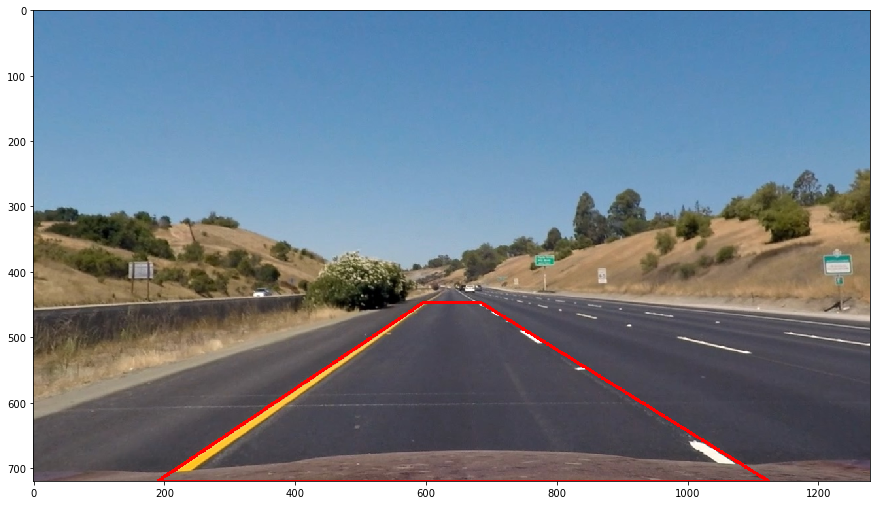

In [0]:
lane_test_undist_cp = lane_test_undist.copy()
plt.figure(figsize = (15, 15))
plt.imshow(cv2.polylines(lane_test_undist_cp, np.int32([PRES_SRC_PNTS]), True, (255,0,0), 3));

In [0]:

M = cv2.getPerspectiveTransform(PRES_SRC_PNTS, PRES_DST_PNTS)
M_INV = cv2.getPerspectiveTransform(PRES_DST_PNTS, PRES_SRC_PNTS)
warped = cv2.warpPerspective(lane_test_undist, M, IMG_SIZE, flags=cv2.INTER_LINEAR)
warped2 = cv2.warpPerspective(lane_test_undist2, M, IMG_SIZE, flags=cv2.INTER_LINEAR)

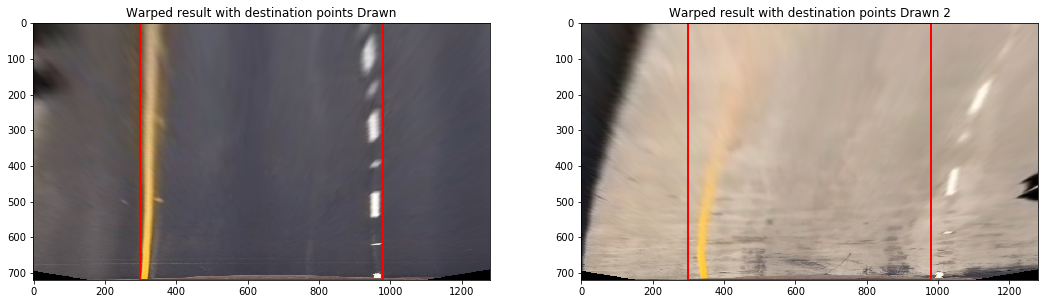

In [0]:
warped_cp = warped.copy()
warped2_cp = warped2.copy()
warped_poly = cv2.polylines(warped_cp, np.int32([PRES_DST_PNTS]), True, (255,0,0), 3)
warped2_poly = cv2.polylines(warped2_cp, np.int32([PRES_DST_PNTS]), True, (255,0,0), 3)

# Draw figure for the two warped lane lines
f, axarr = plt.subplots(1,2)
f.set_size_inches(18, 5)
axarr[0].imshow(warped_poly)
axarr[1].imshow(warped2_poly)
axarr[0].set_title("Warped result with destination points Drawn")
axarr[1].set_title("Warped result with destination points Drawn 2");

In [0]:
N_WINDOWS = 10
MARGIN = 100
RECENTER_MINPIX = 50

# Define conversions in x and y from pixels space to meters
YM_PER_PIX = 30 / 720 # meters per pixel in y dimension
XM_PER_PIX = 3.7 / 700 # meters per pixel in x dimension

In [0]:

def histo_peak(histo):
    """Find left and right peaks of histogram"""
    midpoint = np.int(histo.shape[0]/2)
    leftx_base = np.argmax(histo[:midpoint])
    rightx_base = np.argmax(histo[midpoint:]) + midpoint
    return leftx_base, rightx_base

def get_lane_indices_sliding_windows(binary_warped, leftx_base, rightx_base, n_windows, margin, recenter_minpix):
    """Get lane line pixel indices by using sliding window technique"""
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.copy()
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/n_windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    for window in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > recenter_minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > recenter_minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img

def get_lane_indices_from_prev_window(binary_warped_img, left_fit, right_fit, margin):
    """Detect lane line by searching around detection of previous sliding window detection"""
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_lane_inds, right_lane_inds, ploty, left_fitx, right_fitx

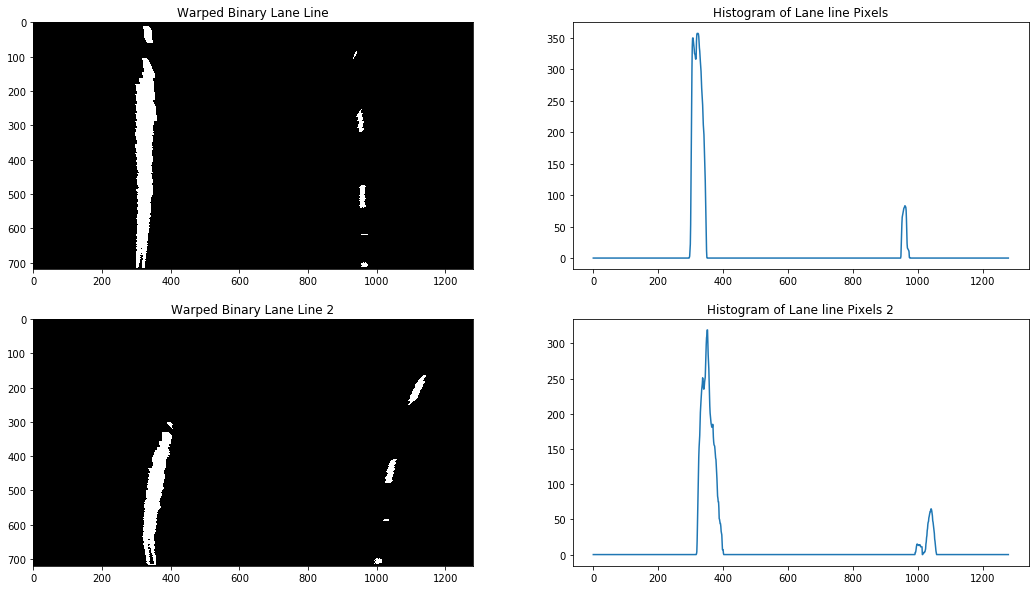

In [0]:
# Warp binary image of lane line
binary_warped = cv2.warpPerspective(s_binary, M, IMG_SIZE, flags=cv2.INTER_LINEAR)
binary_warped2 = cv2.warpPerspective(s_binary2, M, IMG_SIZE, flags=cv2.INTER_LINEAR)

# Calculate histogram of lane line pixels
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
histogram2 = np.sum(binary_warped2[int(binary_warped2.shape[0]/2):,:], axis=0)

# Draw figure for warped binary and histogram
f, axarr = plt.subplots(2,2)
f.set_size_inches(18, 10)
axarr[0, 0].imshow(binary_warped, cmap='gray')
axarr[0, 1].plot(histogram)
axarr[0, 0].set_title("Warped Binary Lane Line")
axarr[0, 1].set_title("Histogram of Lane line Pixels")
axarr[1, 0].imshow(binary_warped2, cmap='gray')
axarr[1, 1].plot(histogram2)
axarr[1, 0].set_title("Warped Binary Lane Line 2")
axarr[1, 1].set_title("Histogram of Lane line Pixels 2");

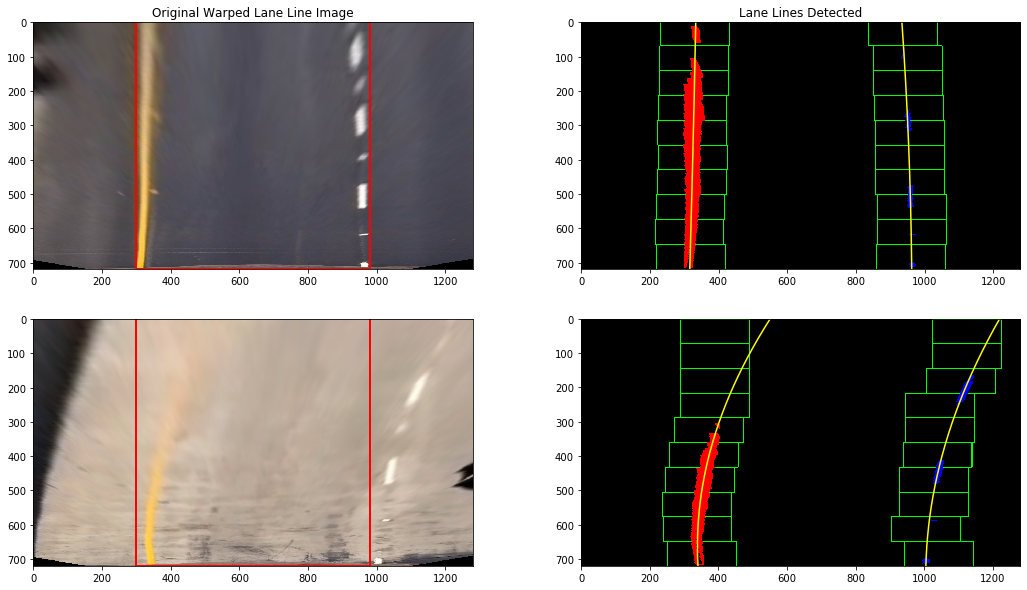

In [0]:
leftx_base, rightx_base = histo_peak(histogram)
left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = get_lane_indices_sliding_windows(
    binary_warped, leftx_base, rightx_base, N_WINDOWS, MARGIN, RECENTER_MINPIX)

leftx_base2, rightx_base2 = histo_peak(histogram2)
left_lane_inds2, right_lane_inds2, nonzerox2, nonzeroy2, out_img2 = get_lane_indices_sliding_windows(
    binary_warped2, leftx_base2, rightx_base2, N_WINDOWS, MARGIN, RECENTER_MINPIX)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

leftx2 = nonzerox2[left_lane_inds2]
lefty2 = nonzeroy2[left_lane_inds2] 
rightx2 = nonzerox2[right_lane_inds2]
righty2 = nonzeroy2[right_lane_inds2] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
left_fit2 = np.polyfit(lefty2, leftx2, 2)
right_fit2 = np.polyfit(righty2, rightx2, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

ploty2 = np.linspace(0, binary_warped2.shape[0]-1, binary_warped2.shape[0] )
left_fitx2 = left_fit2[0]*ploty2**2 + left_fit2[1]*ploty2 + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty2**2 + right_fit2[1]*ploty2 + right_fit2[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
out_img2[nonzeroy2[left_lane_inds2], nonzerox2[left_lane_inds2]] = [255, 0, 0]
out_img2[nonzeroy2[right_lane_inds2], nonzerox2[right_lane_inds2]] = [0, 0, 255]

# Draw figures of line lanes detected
f, axarr = plt.subplots(2,2)
f.set_size_inches(18, 10)
axarr[0, 0].imshow(warped_cp)
axarr[0, 1].imshow(out_img)
axarr[0, 1].plot(left_fitx, ploty, color='yellow')
axarr[0, 1].plot(right_fitx, ploty, color='yellow')
axarr[0, 0].set_title("Original Warped Lane Line Image")
axarr[0, 1].set_title("Lane Lines Detected");
axarr[1, 0].imshow(warped2_cp)
axarr[1, 1].plot(left_fitx2, ploty2, color='yellow')
axarr[1, 1].plot(right_fitx2, ploty2, color='yellow')
axarr[1, 1].imshow(out_img2)
plt.xlim(0, 1280)
plt.ylim(720, 0);

In [0]:
left_lane_inds, right_lane_inds, ploty, left_fitx, right_fitx = get_lane_indices_from_prev_window(
    binary_warped, left_fit, right_fit, MARGIN)

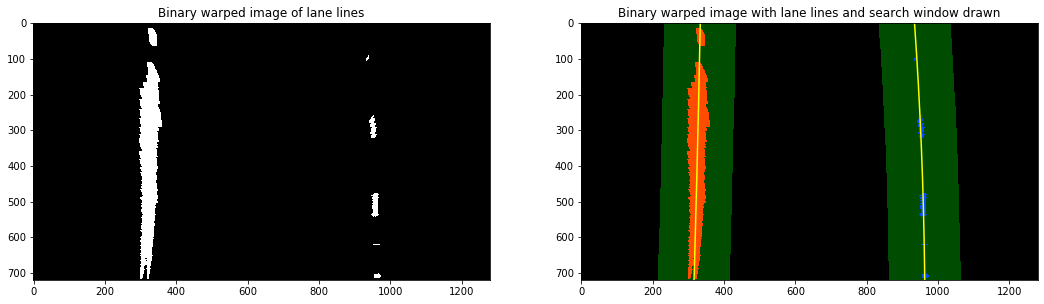

In [0]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-MARGIN, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+MARGIN, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-MARGIN, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+MARGIN, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# Plot the figure
f, axarr = plt.subplots(1,2)
f.set_size_inches(18, 5)
axarr[0].imshow(binary_warped, cmap='gray')
axarr[1].imshow(result)
axarr[1].plot(left_fitx, ploty, color='yellow')
axarr[1].plot(right_fitx, ploty, color='yellow')
axarr[0].set_title("Binary warped image of lane lines")
axarr[1].set_title("Binary warped image with lane lines and search window drawn");

In [0]:
def project_lane_line(original_image, binary_warped, ploty, left_fitx, right_fitx, m_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (original_image.shape[1], original_image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    return result

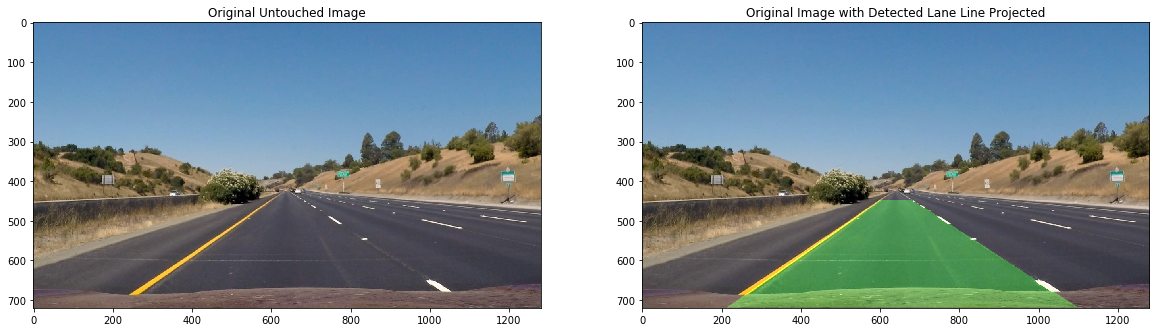

In [0]:
result = project_lane_line(lane_test_img_rgb, binary_warped, ploty, left_fitx, right_fitx, M_INV)

# Plot original image and original image with lane line projected
f, axarr = plt.subplots(1,2)
f.set_size_inches(20, 8)
axarr[0].imshow(lane_test_img_rgb, cmap='gray')
axarr[1].imshow(result)
axarr[0].set_title("Original Untouched Image")
axarr[1].set_title("Original Image with Detected Lane Line Projected");

In [0]:
def calc_curvature(ploty, leftx, rightx, lefty, righty, unit="m"):
    """returns curvature in meters."""
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*YM_PER_PIX, leftx*XM_PER_PIX, 2)
    right_fit_cr = np.polyfit(righty*YM_PER_PIX, rightx*XM_PER_PIX, 2)
    # Calculate the new radii of curvature
    left_curvem = ((1 + (2*left_fit_cr[0]*y_eval*YM_PER_PIX + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curvem = ((1 + (2*right_fit_cr[0]*y_eval*YM_PER_PIX + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curvem, right_curvem

def calc_car_pos(img, left_fit, right_fit):
    # Assuming camera is centered in the image, return position of car in cms.
    car_loc = img.shape[1] / 2

    # Find lane line bottom x-corrdinate
    height = img.shape[0]
    bottom_left = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    bottom_right = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]

    center_lane = (bottom_right - bottom_left)/2 + bottom_left 
    center_offset = ( np.abs(car_loc) - np.abs(center_lane)) * XM_PER_PIX * 100
    return center_offset

In [0]:
left_curvem, right_curvem = calc_curvature(ploty2, leftx2, rightx2, lefty2, righty2)
print(left_curvem, 'm', right_curvem, 'm')

340.95713052462236 m 432.52411868179007 m


In [0]:
left_curvem, right_curvem = calc_curvature(ploty, leftx, rightx, lefty, righty)
print(left_curvem, 'm', right_curvem, 'm')

24770.28508684353 m 3932.804733489705 m


In [0]:
center_offset = calc_car_pos(lane_test_img_rgb, left_fit, right_fit)
print(str(center_offset) + 'cm')

0.3827902797225193cm


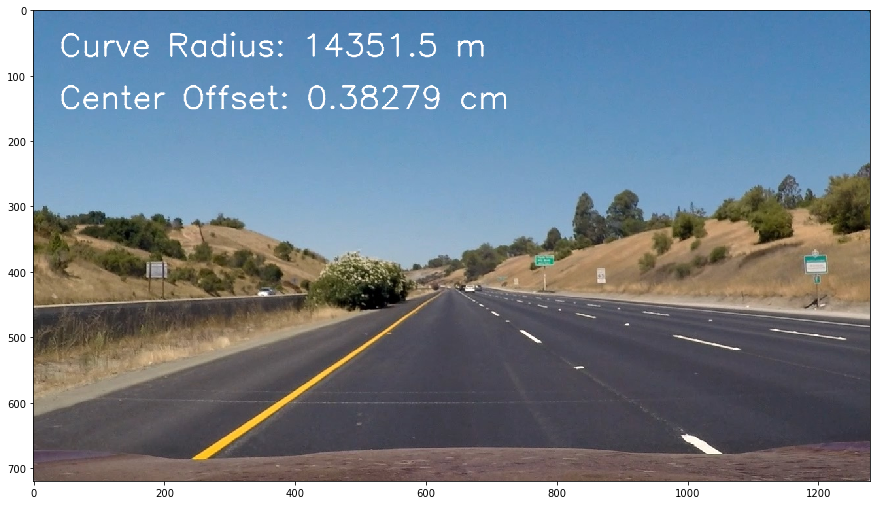

In [0]:
img_cp = lane_test_img_rgb.copy()
cv2.putText(img_cp,'Curve Radius: '+str((left_curvem+right_curvem)/2)[:7]+' m',(40,70), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
cv2.putText(img_cp,'Center Offset: '+str(center_offset)[:7]+' cm',(40,150), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
plt.figure(figsize = (15, 15))
plt.imshow(img_cp)

In [0]:
VID_INPUT = "./challenge_video.mp4"
VID_OUT_DIR = "."
VID_OUTPUT_PATH = VID_OUT_DIR + "/challenge_lane.mp4"

CO_THRES = 5
PIXEL_THRES = 600

In [0]:
global_vars = {
    'left_fit': None,
    'right_fit': None,
    'left_fitx': None,
    'right_fitx': None,
    'co': 0
}

In [0]:
class Line():
    """Class to represent the characteristics of each line detection"""
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
def run_pipeline(image):
    # Preprocess Image
    image_undist = cv2.undistort(image, MTX, DIST, None, MTX)
    s_binary = binary_threshold_lab_luv(image_undist, B_CHANNEL_THRESH, L2_CHANNEL_THRESH)
    binary_warped = cv2.warpPerspective(s_binary, M, IMG_SIZE, flags=cv2.INTER_LINEAR)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    # Identify Lane Lines using sliding window
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    leftx_base, rightx_base = histo_peak(histogram)
    left_lane_inds, right_lane_inds, nonzerox, nonzeroy, out_img = get_lane_indices_sliding_windows(
        binary_warped, leftx_base, rightx_base, N_WINDOWS, MARGIN, RECENTER_MINPIX
    )
    if len(right_lane_inds) < PIXEL_THRES:
        result = project_lane_line(
            image_undist, binary_warped, ploty, global_vars['left_fitx'], global_vars['right_fitx'], M_INV
        )
    else:
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        co = calc_car_pos(image, left_fit, right_fit)
        left_curvem, right_curvem = calc_curvature(ploty, leftx, rightx, lefty, righty)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_curvem, right_curvem = calc_curvature(ploty, leftx, rightx, lefty, righty)
        result = project_lane_line(image_undist, binary_warped, ploty, left_fitx, right_fitx, M_INV)
        global_vars['left_fitx'] = left_fitx
        global_vars['right_fitx'] = right_fitx
        global_vars['left_curvem'] = left_curvem
        global_vars['right_curvem'] = right_curvem
        global_vars['co'] = co

    cv2.putText(result,'Curve Radius: '+str((global_vars['left_curvem']+global_vars['right_curvem'])/2)[:7]+' m',(40,70), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Center Offset: '+str(global_vars['co'])[:7]+' cm',(40,150), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
    return result


In [0]:
if not os.path.exists(VID_OUT_DIR):
    os.makedirs(VID_OUT_DIR)

# Process each frame in the project video input and output a new video with lane lines projected
clip = VideoFileClip(VID_INPUT)
new_clip = clip.fl_image(run_pipeline)
new_clip.write_videofile(VID_OUTPUT_PATH, audio=False, verbose=False)
                       #  progress_bar=False)

                                                               
t:  11%|█         | 135/1260 [02:03<01:16, 14.75it/s, now=None]
                                                               
t:  13%|█▎        | 159/1233 [01:22<01:11, 15.03it/s, now=None]

t:   0%|          | 0/1233 [00:00<?, ?it/s, now=None]

t:   0%|          | 3/1233 [00:00<00:54, 22.52it/s, now=None]

Moviepy - Building video repo/video_results/challenge_object_output.mp4.
Moviepy - Writing video repo/video_results/challenge_object_output.mp4





t:   0%|          | 5/1233 [00:00<01:03, 19.28it/s, now=None]

t:   1%|          | 7/1233 [00:00<01:09, 17.56it/s, now=None]

t:   1%|          | 9/1233 [00:00<01:12, 16.86it/s, now=None]

t:   1%|          | 11/1233 [00:00<01:14, 16.36it/s, now=None]

t:   1%|          | 13/1233 [00:00<01:17, 15.84it/s, now=None]

t:   1%|          | 15/1233 [00:00<01:18, 15.42it/s, now=None]

t:   1%|▏         | 17/1233 [00:01<01:19, 15.27it/s, now=None]

t:   2%|▏         | 19/1233 [00:01<01:19, 15.21it/s, now=None]

t:   2%|▏         | 21/1233 [00:01<01:19, 15.17it/s, now=None]

t:   2%|▏         | 23/1233 [00:01<01:19, 15.14it/s, now=None]

t:   2%|▏         | 25/1233 [00:01<01:20, 14.93it/s, now=None]

t:   2%|▏         | 27/1233 [00:01<01:20, 14.95it/s, now=None]

t:   2%|▏         | 29/1233 [00:01<01:21, 14.77it/s, now=None]

t:   3%|▎         | 31/1233 [00:02<01:20, 14.86it/s, now=None]

t:   3%|▎         | 33/1233 [00:02<01:20, 14.97it/s, now=None]

t:   3%|▎         | 35/1233 [00:02<01:19,

t:  19%|█▉        | 237/1233 [00:16<01:15, 13.20it/s, now=None]

t:  19%|█▉        | 239/1233 [00:16<01:15, 13.23it/s, now=None]

t:  20%|█▉        | 241/1233 [00:16<01:16, 12.94it/s, now=None]

t:  20%|█▉        | 243/1233 [00:16<01:15, 13.14it/s, now=None]

t:  20%|█▉        | 245/1233 [00:17<01:15, 13.03it/s, now=None]

t:  20%|██        | 247/1233 [00:17<01:16, 12.96it/s, now=None]

t:  20%|██        | 249/1233 [00:17<01:14, 13.16it/s, now=None]

t:  20%|██        | 251/1233 [00:17<01:14, 13.22it/s, now=None]

t:  21%|██        | 253/1233 [00:17<01:16, 12.88it/s, now=None]

t:  21%|██        | 255/1233 [00:17<01:15, 12.90it/s, now=None]

t:  21%|██        | 257/1233 [00:18<01:14, 13.16it/s, now=None]

t:  21%|██        | 259/1233 [00:18<01:13, 13.25it/s, now=None]

t:  21%|██        | 261/1233 [00:18<01:10, 13.72it/s, now=None]

t:  21%|██▏       | 263/1233 [00:18<01:09, 14.04it/s, now=None]

t:  21%|██▏       | 265/1233 [00:18<01:08, 14.10it/s, now=None]

t:  22%|██▏       | 267/1

t:  38%|███▊      | 467/1233 [00:32<00:53, 14.22it/s, now=None]

t:  38%|███▊      | 469/1233 [00:32<00:54, 14.13it/s, now=None]

t:  38%|███▊      | 471/1233 [00:32<00:54, 14.04it/s, now=None]

t:  38%|███▊      | 473/1233 [00:32<00:53, 14.12it/s, now=None]

t:  39%|███▊      | 475/1233 [00:33<00:53, 14.27it/s, now=None]

t:  39%|███▊      | 477/1233 [00:33<00:52, 14.29it/s, now=None]

t:  39%|███▉      | 479/1233 [00:33<00:53, 14.12it/s, now=None]

t:  39%|███▉      | 481/1233 [00:33<00:54, 13.77it/s, now=None]

t:  39%|███▉      | 483/1233 [00:33<00:54, 13.89it/s, now=None]

t:  39%|███▉      | 485/1233 [00:33<00:54, 13.75it/s, now=None]

t:  39%|███▉      | 487/1233 [00:33<00:54, 13.77it/s, now=None]

t:  40%|███▉      | 489/1233 [00:34<00:53, 13.82it/s, now=None]

t:  40%|███▉      | 491/1233 [00:34<00:53, 13.88it/s, now=None]

t:  40%|███▉      | 493/1233 [00:34<00:52, 14.10it/s, now=None]

t:  40%|████      | 495/1233 [00:34<00:52, 14.17it/s, now=None]

t:  40%|████      | 497/1

t:  57%|█████▋    | 697/1233 [00:47<00:35, 14.93it/s, now=None]

t:  57%|█████▋    | 699/1233 [00:47<00:35, 14.88it/s, now=None]

t:  57%|█████▋    | 701/1233 [00:48<00:36, 14.42it/s, now=None]

t:  57%|█████▋    | 703/1233 [00:48<00:35, 14.81it/s, now=None]

t:  57%|█████▋    | 705/1233 [00:48<00:35, 14.76it/s, now=None]

t:  57%|█████▋    | 707/1233 [00:48<00:35, 14.92it/s, now=None]

t:  58%|█████▊    | 709/1233 [00:48<00:35, 14.85it/s, now=None]

t:  58%|█████▊    | 711/1233 [00:48<00:34, 14.98it/s, now=None]

t:  58%|█████▊    | 713/1233 [00:48<00:34, 14.93it/s, now=None]

t:  58%|█████▊    | 715/1233 [00:48<00:34, 14.97it/s, now=None]

t:  58%|█████▊    | 717/1233 [00:49<00:34, 15.04it/s, now=None]

t:  58%|█████▊    | 719/1233 [00:49<00:33, 15.15it/s, now=None]

t:  58%|█████▊    | 721/1233 [00:49<00:33, 15.13it/s, now=None]

t:  59%|█████▊    | 723/1233 [00:49<00:33, 15.01it/s, now=None]

t:  59%|█████▉    | 725/1233 [00:49<00:33, 14.97it/s, now=None]

t:  59%|█████▉    | 727/1

t:  75%|███████▌  | 927/1233 [01:03<00:21, 13.94it/s, now=None]

t:  75%|███████▌  | 929/1233 [01:03<00:21, 14.02it/s, now=None]

t:  76%|███████▌  | 931/1233 [01:03<00:21, 13.99it/s, now=None]

t:  76%|███████▌  | 933/1233 [01:04<00:21, 14.15it/s, now=None]

t:  76%|███████▌  | 935/1233 [01:04<00:20, 14.20it/s, now=None]

t:  76%|███████▌  | 937/1233 [01:04<00:21, 14.06it/s, now=None]

t:  76%|███████▌  | 939/1233 [01:04<00:20, 14.11it/s, now=None]

t:  76%|███████▋  | 941/1233 [01:04<00:20, 13.99it/s, now=None]

t:  76%|███████▋  | 943/1233 [01:04<00:20, 13.97it/s, now=None]

t:  77%|███████▋  | 945/1233 [01:04<00:20, 14.02it/s, now=None]

t:  77%|███████▋  | 947/1233 [01:05<00:20, 14.05it/s, now=None]

t:  77%|███████▋  | 949/1233 [01:05<00:20, 13.72it/s, now=None]

t:  77%|███████▋  | 951/1233 [01:05<00:20, 13.51it/s, now=None]

t:  77%|███████▋  | 953/1233 [01:05<00:20, 13.66it/s, now=None]

t:  77%|███████▋  | 955/1233 [01:05<00:20, 13.82it/s, now=None]

t:  78%|███████▊  | 957/1

t:  94%|█████████▎| 1155/1233 [01:19<00:05, 14.12it/s, now=None]

t:  94%|█████████▍| 1157/1233 [01:19<00:05, 14.24it/s, now=None]

t:  94%|█████████▍| 1159/1233 [01:19<00:05, 14.04it/s, now=None]

t:  94%|█████████▍| 1161/1233 [01:20<00:05, 14.11it/s, now=None]

t:  94%|█████████▍| 1163/1233 [01:20<00:04, 14.14it/s, now=None]

t:  94%|█████████▍| 1165/1233 [01:20<00:04, 14.08it/s, now=None]

t:  95%|█████████▍| 1167/1233 [01:20<00:04, 13.74it/s, now=None]

t:  95%|█████████▍| 1169/1233 [01:20<00:04, 13.71it/s, now=None]

t:  95%|█████████▍| 1171/1233 [01:20<00:04, 13.66it/s, now=None]

t:  95%|█████████▌| 1173/1233 [01:21<00:04, 13.71it/s, now=None]

t:  95%|█████████▌| 1175/1233 [01:21<00:04, 13.83it/s, now=None]

t:  95%|█████████▌| 1177/1233 [01:21<00:04, 13.89it/s, now=None]

t:  96%|█████████▌| 1179/1233 [01:21<00:03, 13.96it/s, now=None]

t:  96%|█████████▌| 1181/1233 [01:21<00:03, 13.79it/s, now=None]

t:  96%|█████████▌| 1183/1233 [01:21<00:03, 13.89it/s, now=None]

t:  96%|██

Moviepy - Done !
Moviepy - video ready repo/video_results/challenge_object_output.mp4
